#  Construction of hmm profile using a set of sequences 

## states_define function outputs all hidden states in the profile hmm graph given length(sequence)-1 as input  , by sequence I mean a alignment ex. "AT_GC_"

In [1]:
def states_define(nn):
    hidden_states = ["S0", 'I0']
    for i in range(nn):
        hidden_states.append('M'+str(i+1))
        hidden_states.append('D'+str(i+1))
        hidden_states.append('I'+str(i+1))
    hidden_states.append('E')
    return hidden_states

## Returns the index of a element from the array, the element is present in

In [2]:
def where(a,b):
    x=list(idx for idx, val in np.ndenumerate(a) if val==b)[0][0]
    return(x)

## counts the no. of gaps in each column from a array containing all the alignments , if the no. of gaps is greater than a particular threshold value it sets the array x at the same index as column to 0 and if no. of gaps is less than a threshold it sets it as 1.

In [3]:
import numpy as np
def check(alignments,threshold):
    ll=len(alignments[0])
    x=np.ones(ll)
    l=len(alignments)
    for i in range(ll):
        s=0
        for j in range(l):
            if alignments[j][i]=="-":
                s+=1/l
        if s>threshold:
            x[i]=0.0
    return(x)

# construction of profile hmm, using alignments provided . every time a edge is traversed 1 is added to the edge of a profile hmm graph.Please refer to the image attached with the mail, where the process is pictorically explained. basically each alignment is a path in the graph 

In [4]:
import numpy as np
def profile_hmm(observations,alignments,hidden_states,true_matrix):
    trans_mat=np.zeros((len(hidden_states),len(hidden_states)))
    emiss_mat=np.zeros((len(hidden_states),len(observations)))
    length=len(alignments[0])
    for seq in alignments:
        cur_hidden_state="S0"
        for i in range(length):
            if true_matrix[i]:
                if seq[i] in observations:
                    new_hidden_state="M"+str(int(cur_hidden_state[1:])+1)
                    #print(new_hidden_state)
                    trans_mat[where(hidden_states,cur_hidden_state)][where(hidden_states,new_hidden_state)]+=1
                    emiss_mat[where(hidden_states,new_hidden_state)][where(observations,seq[i])]+=1
                    cur_hidden_state=new_hidden_state
                else:
                    new_hidden_state = 'D'+str(int(cur_hidden_state[1:])+1)
                    trans_mat[where(hidden_states,cur_hidden_state)][where(hidden_states,new_hidden_state)] += 1
                    cur_hidden_state = new_hidden_state     
            else:
                if seq[i] in observations:
                    new_hidden_state = 'I'+str(int(cur_hidden_state[1:]))
                    trans_mat[where(hidden_states,cur_hidden_state)][where(hidden_states,new_hidden_state)] += 1
                    emiss_mat[where(hidden_states,new_hidden_state)][where(observations,seq[i])] += 1
                    cur_hidden_state = new_hidden_state
        new_hidden_state = 'E'
        trans_mat[where(hidden_states,cur_hidden_state)][where(hidden_states,new_hidden_state)] += 1
    return trans_mat, emiss_mat   

# adds puedocount and normailzation 

In [5]:
def add_pseudo(hid, inc, trans, emit, pseud):
    for index, item in enumerate(hid):
        if item == 'E':
            continue
        if item[0] in ['I', 'M']:
            new = [x+pseud for x in emit[index]]
            emit[index] = new
        s = item[1:]
        if int(s) < inc:
            possible_moves = ['I'+s, 'M'+str(int(s)+1), 'D'+str(int(s)+1)]
            for new_item in possible_moves:
                trans[index][where(hid,new_item)] += pseud
        elif int(s) == inc:
            possible_moves = ['I'+s, 'E']
            for new_item in possible_moves:
                trans[index][where(hid,new_item)] += pseud
    for i, line in enumerate(trans):
        s = sum(line)
        if s > 0:
            normalized = [x/s for x in line]
            trans[i] = normalized

    for i, line in enumerate(emit):
        s = sum(line)
        if s > 0:
            normalized = [x/s for x in line]
            emit[i] = normalized
    return trans, emit

# viterbi algorithm for profile hmm

In [6]:
from math import log10
from operator import itemgetter
from copy import copy
def generate_viterbi(sequence, inc, hid, tran, emit,states):
    viterbi = list()
    column = dict()
    column['S0'] = (0, 0, 'Source')
    column['D1'] = (log10(tran[hid.index('S0')][hid.index('D1')]), 0, 'S0')
    for i in range(1, inc+1):
        column['D'+str(i+1)] = (log10(tran[hid.index('D'+str(i))][hid.index('D'+str(i+1))]) + column['D'+str(i)][0], 0, 'D'+str(i))
    viterbi.append(copy(column))
    for j, lett in enumerate(sequence):
        column = dict()
        if not j:
            column['I0'] = (log10(tran[hid.index('S0')][hid.index('I0')]) + log10(emit[hid.index('I0')][states.index(lett)]), 0, 'S0')
            column['M1'] = (log10(tran[hid.index('S0')][hid.index('M1')]) + log10(emit[hid.index('M1')][states.index(lett)]), 0, 'S0')
            column['D1'] = (column['I0'][0] + log10(tran[hid.index('I0')][hid.index('D1')]), 1, 'I0')
            for stat in hid[4:-1]:
                l = stat[0]
                ind = int(stat[1:])
                if l == 'I':
                    fath = 'D'+str(ind)
                    column[stat] = (viterbi[j][fath][0] + log10(tran[hid.index(fath)][hid.index(stat)]) + log10(emit[hid.index(stat)][states.index(lett)]), 0, fath)
                if l == 'M':
                    fath = 'D'+str(ind-1)
                    column[stat] = (viterbi[j][fath][0] + log10(tran[hid.index(fath)][hid.index(stat)]) + log10(emit[hid.index(stat)][states.index(lett)]), 0, fath)
                if l == 'D':
                    temp = str(ind-1)
                    fathers = [tt+temp for tt in ['I', 'M', 'D']]
                    proba = [(column[fath][0] + log10(tran[hid.index(fath)][hid.index(stat)]), j+1, fath) for fath in fathers]
                    column[stat] = max(proba, key=itemgetter(0))
            viterbi.append(copy(column))
        else:
            column['I0'] = (viterbi[j]['I0'][0] + log10(tran[hid.index('I0')][hid.index('I0')]) + log10(emit[hid.index('I0')][states.index(lett)]), j, 'I0')
            column['M1'] = (viterbi[j]['I0'][0] + log10(tran[hid.index('I0')][hid.index('M1')]) + log10(emit[hid.index('M1')][states.index(lett)]), j, 'I0')
            column['D1'] = (column['I0'][0] + log10(tran[hid.index('I0')][hid.index('D1')]), 1, 'I0')
            for stat in hid[4:-1]:
                l = stat[0]
                ind = int(stat[1:])
                if l == 'I':
                    temp = str(ind)
                    fathers = [tt+temp for tt in ['I', 'M', 'D']]
                    proba = [(viterbi[j][fath][0] + log10(tran[hid.index(fath)][hid.index(stat)]) + log10(emit[hid.index(stat)][states.index(lett)]), j, fath) for fath in fathers]
                if l == 'M':
                    temp = str(ind-1)
                    fathers = [tt+temp for tt in ['I', 'M', 'D']]
                    proba = [(viterbi[j][fath][0] + log10(tran[hid.index(fath)][hid.index(stat)]) + log10(emit[hid.index(stat)][states.index(lett)]), j, fath) for fath in fathers]
                if l == 'D':
                    temp = str(ind-1)
                    fathers = [tt+temp for tt in ['I', 'M', 'D']]
                    proba = [(column[fath][0] + log10(tran[hid.index(fath)][hid.index(stat)]), j+1, fath) for fath in fathers]
                column[stat] = max(proba, key=itemgetter(0))
            viterbi.append(copy(column))
    return viterbi

# returns the log probability of all sequences from an hmm made using a single sequence 

In [7]:
def prob(tm,em,hid_states,obs_states,hid,obs):
    p=0
    obs=obs[1:]
    for i in range(len(hid)):
        if obs[i][0]!="-":
            p+=log(em[where(hid_states,hid[i][0])][where(obs_states,obs[i][0])])
        for j in range(1,len(hid[i])):
            p=p+log(tm[where(hid_states,hid[i][j-1])][where(hid_states,hid[i][j])])
            if obs[i][j]!="-":
                p+=log(em[where(hid_states,hid[i][j])][where(obs_states,obs[i][j])])
    return(p)    

# gives all log probablity of each sequence from hmm

In [8]:
def prob_new(tm,em,hid_states,obs_states,hid,obs):
    obs=obs[1:]
    list1=[]
    for i in range(len(hid)):
        p=0
        if obs[i][0]!="-":
            p+=log(em[where(hid_states,hid[i][0])][where(obs_states,obs[i][0])])
        for j in range(1,len(hid[i])):
            p=p+log(tm[where(hid_states,hid[i][j-1])][where(hid_states,hid[i][j])])
            if obs[i][j]!="-":
                p+=log(em[where(hid_states,hid[i][j])][where(obs_states,obs[i][j])])
        list1.append(p)
    return(list1)    

# hierarchical clustering

In [9]:
import networkx as nx
def h_clustr(matrix,n):
    clusters=[]
    for i in range(n):
        clusters.append([i])
    #print(clusters)
    nodes=[]
    for j in range(n):
        nodes.append(str([j]))
    t=nx.DiGraph()
    t.add_nodes_from(nodes)
    while len(clusters)>1:
        close_c=search(clusters,matrix)
        #print(close_c)
        c_new=close_c[0]+close_c[1]
        t.add_node(str(c_new))
        t.add_edges_from([(str(close_c[0]),str(c_new)),(str(close_c[1]),str(c_new))])
        clusters.append(c_new)
        clusters.remove(close_c[0])
        clusters.remove(close_c[1])
        for i in close_c:
            for j in i:
                print(j+1, end =" ")
        print("\n")
    for i in close_c:
            for j in i:
                print(j+1, end =" ")
    return(t,nodes)

# set of passing sequences obtained from FCB VS REAL ESPANYOL

In [10]:
seqs=[['Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Lucas Digne',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer',
  'Neymar da Silva Santos Junior',
  'Sergi Roberto Carnicer',
  'Sergi Roberto Carnicer'],
 ['Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Neymar da Silva Santos Junior',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Samuel Yves Umtiti',
  'Neymar da Silva Santos Junior',
  'Ivan RakitiÄ‡',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Neymar da Silva Santos Junior'],
 ['Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Neymar da Silva Santos Junior',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Rafael AlcÃ¢ntara do Nascimento'],
 ['Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Ivan RakitiÄ‡',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Samuel Yves Umtiti'],
 ['Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Neymar da Silva Santos Junior',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano'],
 ['Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Neymar da Silva Santos Junior',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Sergi Roberto Carnicer',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Neymar da Silva Santos Junior'],
 ['Lucas Digne'],
 ['Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Neymar da Silva Santos Junior'],
 ['Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti'],
 ['Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Neymar da Silva Santos Junior',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Neymar da Silva Santos Junior',
  'Rafael AlcÃ¢ntara do Nascimento'],
 ['Sergi Roberto Carnicer', 'Ivan RakitiÄ‡', 'Javier Alejandro Mascherano'],
 ['Lucas Digne',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Neymar da Silva Santos Junior'],
 ['Samuel Yves Umtiti',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Luis Alberto SuÃ¡rez DÃ\xadaz'],
 ['Javier Alejandro Mascherano', 'Ivan RakitiÄ‡'],
 ['Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Ivan RakitiÄ‡',
  'Denis SuÃ¡rez FernÃ¡ndez'],
 ['Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Marc-AndrÃ© ter Stegen',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Marc-AndrÃ© ter Stegen',
  'Sergi Roberto Carnicer',
  'Neymar da Silva Santos Junior'],
 ['Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Lucas Digne',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Neymar da Silva Santos Junior'],
 ['Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Rafael AlcÃ¢ntara do Nascimento'],
 ['Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Neymar da Silva Santos Junior',
  'Samuel Yves Umtiti'],
 ['Sergi Roberto Carnicer', 'Javier Alejandro Mascherano'],
 ['Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Neymar da Silva Santos Junior',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Lucas Digne',
  'Sergi Roberto Carnicer',
  'Neymar da Silva Santos Junior',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Neymar da Silva Santos Junior',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Sergi Roberto Carnicer',
  'Lucas Digne',
  'Neymar da Silva Santos Junior',
  'Neymar da Silva Santos Junior'],
 ['Marc-AndrÃ© ter Stegen',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez'],
 ['Lucas Digne',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano'],
 ['Ivan RakitiÄ‡',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez'],
 ['Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Rafael AlcÃ¢ntara do Nascimento'],
 ['Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Ivan RakitiÄ‡',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer'],
 ['Marc-AndrÃ© ter Stegen',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano'],
 ['Ivan RakitiÄ‡',
  'Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Neymar da Silva Santos Junior'],
 ['Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Marc-AndrÃ© ter Stegen',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Javier Alejandro Mascherano',
  'Lucas Digne',
  'Samuel Yves Umtiti',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Javier Alejandro Mascherano',
  'Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Luis Alberto SuÃ¡rez DÃ\xadaz'],
 ['Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Lucas Digne',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer',
  'Ivan RakitiÄ‡'],
 ['Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti'],
 ['Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Sergi Roberto Carnicer',
  'Lucas Digne',
  'Sergi Roberto Carnicer',
  'Lucas Digne',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Lucas Digne',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer'],
 ['Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior'],
 ['Lucas Digne',
  'Ivan RakitiÄ‡',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer'],
 ['Rafael AlcÃ¢ntara do Nascimento',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Marc-AndrÃ© ter Stegen',
  'Samuel Yves Umtiti',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Luis Alberto SuÃ¡rez DÃ\xadaz'],
 ['Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Denis SuÃ¡rez FernÃ¡ndez',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Sergi Roberto Carnicer',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Samuel Yves Umtiti',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Lionel AndrÃ©s Messi Cuccittini'],
 ['Lucas Digne',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior'],
 ['Sergi Roberto Carnicer'],
 ['Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Neymar da Silva Santos Junior',
  'Luis Alberto SuÃ¡rez DÃ\xadaz',
  'Lucas Digne',
  'Sergi Roberto Carnicer',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Ivan RakitiÄ‡',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano'],
 ['Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Ivan RakitiÄ‡',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Ivan RakitiÄ‡',
  'Lionel AndrÃ©s Messi Cuccittini',
  'Sergi Roberto Carnicer',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Javier Alejandro Mascherano',
  'Marc-AndrÃ© ter Stegen',
  'Samuel Yves Umtiti'],
 ['Ivan RakitiÄ‡',
  'Neymar da Silva Santos Junior',
  'Rafael AlcÃ¢ntara do Nascimento'],
 ['Sergi Roberto Carnicer',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Ivan RakitiÄ‡',
  'Lucas Digne',
  'Lucas Digne'],
 ['Lucas Digne',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Samuel Yves Umtiti',
  'Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Rafael AlcÃ¢ntara do Nascimento',
  'Ivan RakitiÄ‡',
  'Samuel Yves Umtiti',
  'Javier Alejandro Mascherano',
  'Sergi Roberto Carnicer',
  'Javier Alejandro Mascherano',
  'Marc-AndrÃ© ter Stegen',
  'Samuel Yves Umtiti',
  'Lucas Digne',
  'Ivan RakitiÄ‡',
  'Marc-AndrÃ© ter Stegen',
  'Samuel Yves Umtiti',
  'Marc-AndrÃ© ter Stegen',
  'Javier Alejandro Mascherano',
  'Rafael AlcÃ¢ntara do Nascimento']]

In [11]:
from math import log
t=0.34
distance_matrix=[]
def function(yy,t):    
    paths=[]
    for i in seqs:
        obs1=['Marc-AndrÃ© ter Stegen',
 'Sergi Roberto Carnicer',
 'Javier Alejandro Mascherano',
 'Samuel Yves Umtiti',
 'Lucas Digne',
 'Ivan RakitiÄ‡',
 'Denis SuÃ¡rez FernÃ¡ndez',
 'Rafael AlcÃ¢ntara do Nascimento',
 'Lionel AndrÃ©s Messi Cuccittini',
 'Neymar da Silva Santos Junior',
 'Luis Alberto SuÃ¡rez DÃ\xadaz']
        tm=check(yy,t)
        s=states_define(len(yy[0]))
        x,y=profile_hmm(obs1,yy,s,tm)
        x1,y1=add_pseudo(s, len(yy[0]), x, y, 0.5)
        v=generate_viterbi(i,len(yy[0])-1, s, x1, y1,obs1)
        path = list()
        final_states = [tt+str(len(yy[0])) for tt in ['M', 'D', 'I']]
        proba = [(v[-1][fath][0] + log10(x1[s.index(fath)][s.index('E')]), len(i), fath) for fath in final_states]
        exit_state = max(proba, key=itemgetter(0))
        pointer = exit_state[1], exit_state[2]
        while True:
            path.append(pointer[1])
            back = v[pointer[0]][pointer[1]]
            pointer = back[1], back[2]
            if pointer[1] == 'S0':
                break
        x=0
        seq=[]
        path_=[]
        for j in path[::-1]:
            path_.append(j)
            if j[0]=="M" or j[0]=="I":
                seq.append(i[x])
                x=x+1
            else:
                seq.append("-")
        yy.append(seq)
        paths.append(path_)
    p=prob(x1,y1,s,obs1,paths,yy)
    distance_matrix.append(prob_new(x1,y1,s,obs1,paths,yy))
    return(p)

In [12]:
import time 
min_val=-4000
min_index=0
for i in seqs:
    yy=[i]
    m=function(yy,t)
    if m>min_val:
        min_val=m
        min_index=i

In [16]:
centers=farthestfirst(distance_matrix,10)

In [18]:
distance_matrix=np.array(distance_matrix)
for i in range(len(distance_matrix)):
    distance_matrix[i]=distance_matrix[i]*-1

In [19]:
def search(clusters,matrix):
    d_min=1000000000000
    close_c=[]
    for i in range(len(clusters)):
        for j in range(i+1,len(clusters)):
            d=0
            for m1 in clusters[i]:
                for m2 in clusters[j]:
                    d+=matrix[m1][m2]
            d=d/(len(clusters[i])*len(clusters[j]))
            if (d<d_min):
                close_c=[]
                close_c=[clusters[i],clusters[j]]
                d_min=d
    return(close_c)

In [20]:
graph,nodes=h_clustr(distance_matrix,49)

9 44 

17 23 

3 9 44 

14 17 23 

26 14 17 23 

25 26 14 17 23 

47 25 26 14 17 23 

31 47 25 26 14 17 23 

10 18 

16 10 18 

40 31 47 25 26 14 17 23 

27 40 31 47 25 26 14 17 23 

35 27 40 31 47 25 26 14 17 23 

29 16 10 18 

21 3 9 44 

36 35 27 40 31 47 25 26 14 17 23 

33 21 3 9 44 

13 36 35 27 40 31 47 25 26 14 17 23 

33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

43 32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

4 43 32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

6 4 43 32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

48 6 4 43 32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

46 48 6 4 43 32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

2 46 48 6 4 43 32 29 16 10 18 33 21 3 9 44 13 36 35 27 40 31 47 25 26 14 17 23 

22 2 46 48 6 4 43 32 29 16 10 18 33 21 3 9

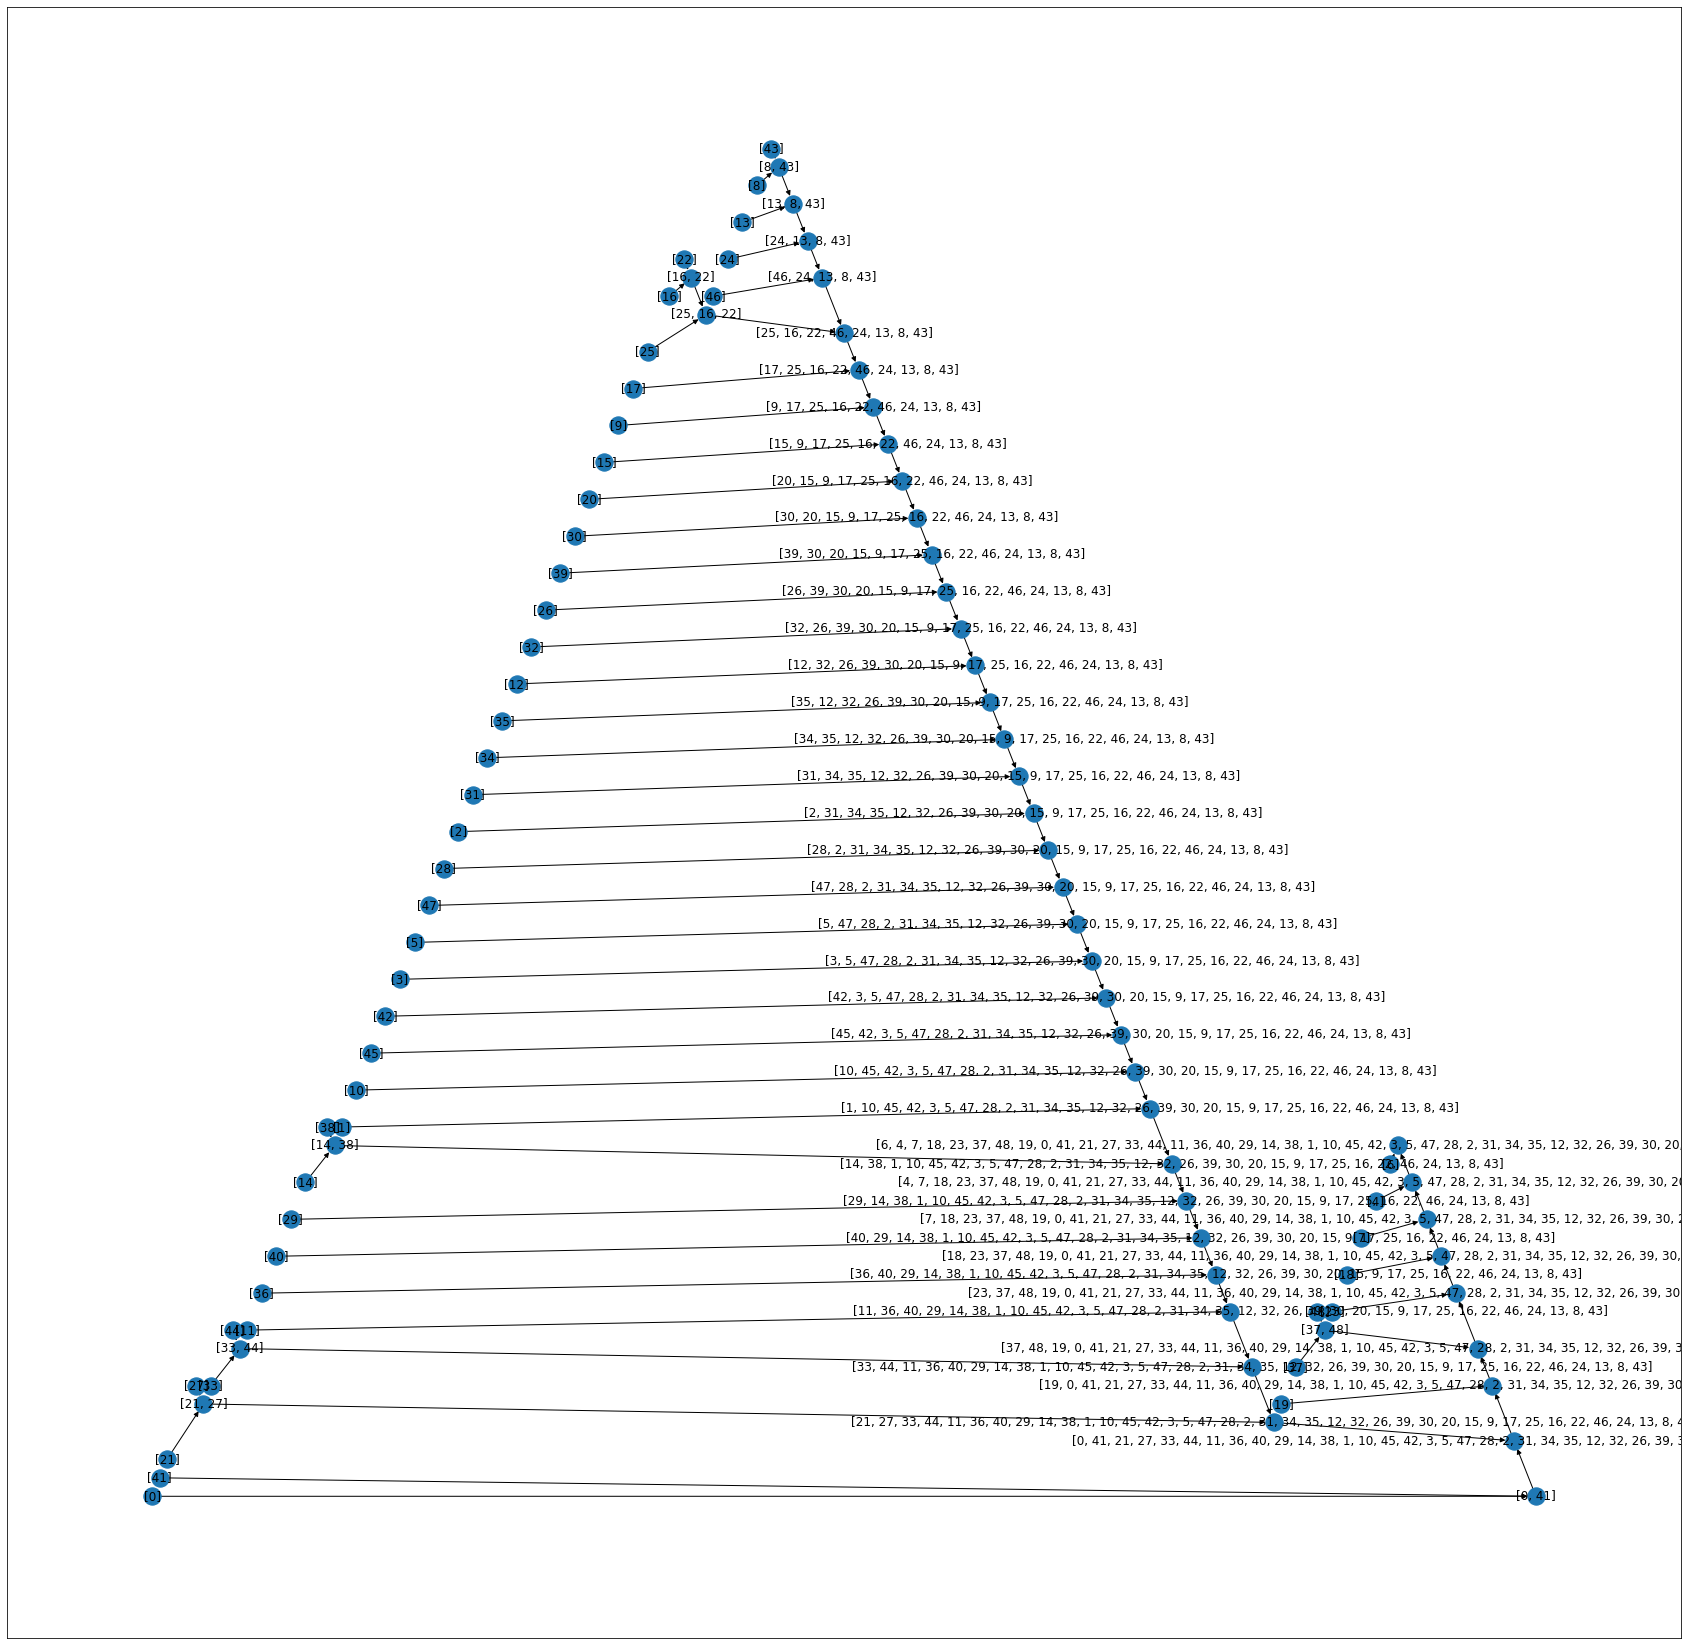

In [231]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
pos=nx.planar_layout(graph)
nx.draw_networkx(graph,pos)

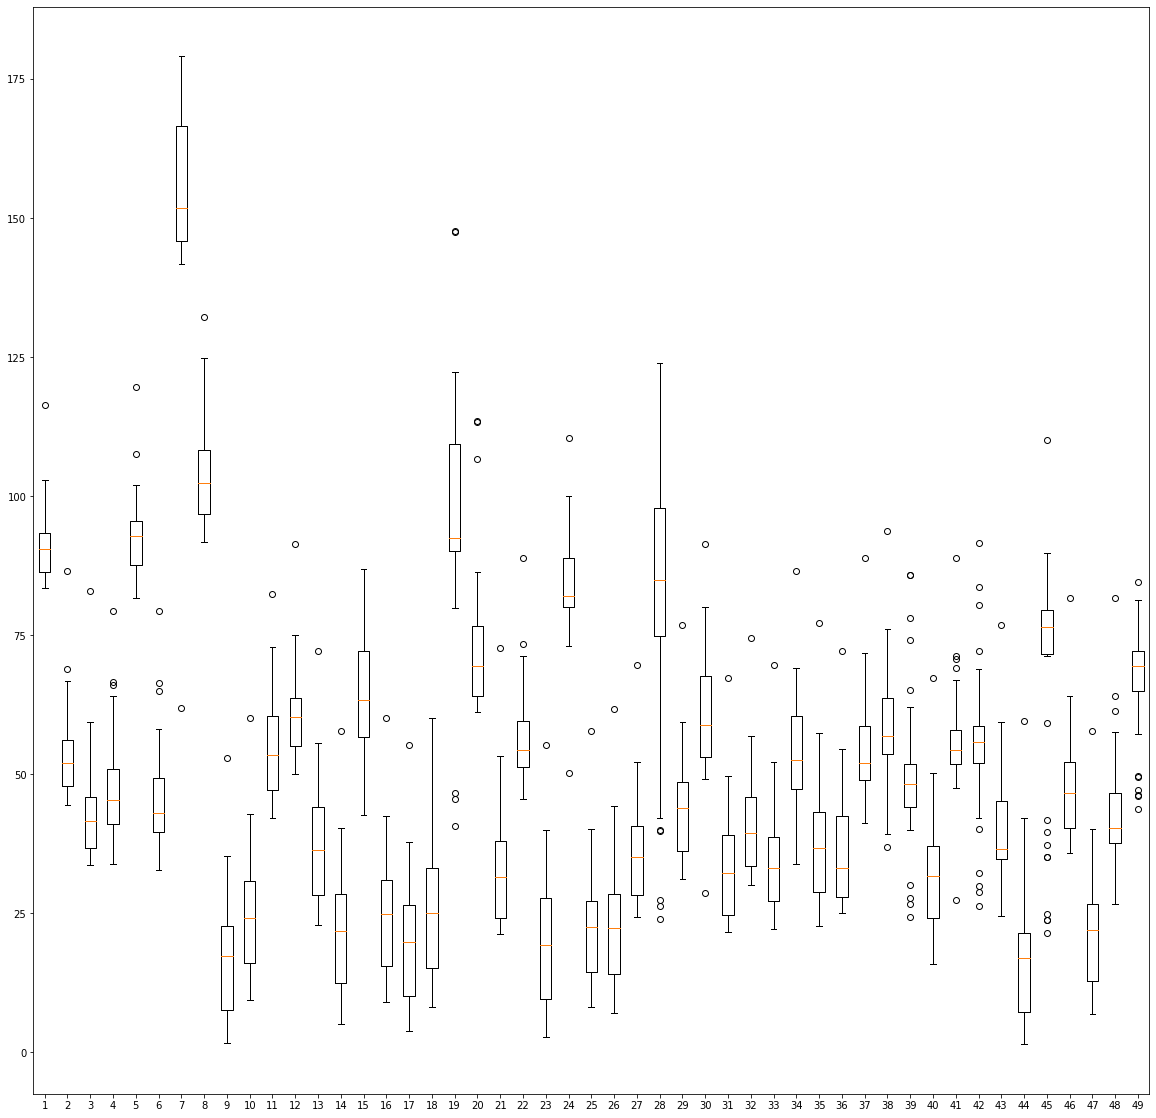

In [239]:
plt.figure(figsize=(20,20))
plt.boxplot(distance_matrix)
plt.show()

In [14]:
def farthestfirst(data,k):
    centers=[data[0]]
    data=data[1:]
    while len(centers)<k:
        d_cur=0
        d_max=0
        new_cen=0
        for i in data:
            d_cur=distance(i,centers)
            if d_cur>d_max:
                new_cen=i
                d_max=d_cur
        centers.append(new_cen)
        data.remove(new_cen)
    return(centers)            

In [15]:
def distance(dpoint,centers):
    length=0
    length_f=0
    for i in centers:
        list1=[]
        for j in range(len(i)):
            length+=(dpoint[j]-i[j])**2
        length=length**0.5
        list1.append(length)
    length_f=max(list1)
    return(length_f)

In [28]:
from collections import defaultdict
def llyod_algo(data,k,n):
    centers=data[0:k]
    dict_={}
    while (n>0):
        for i in range(len(data)):
            dict_[i]=close_cent(data[i],centers)
        cluster=defaultdict(list)
        for key,val in sorted(dict_.items()):
            cluster[val].append(key)
        for j in cluster:
            cg=cog(cluster[j],data)
            centers[j]=cg
        n=n-1
    return(centers,cluster)

In [24]:
def close_cent(data,centers):
    length=0
    length_f=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    x=0
    for i in range(len(centers)):
        length=0
        for j in range(len(centers[i])):
            length+=(data[j]-centers[i][j])**2
        if length<length_f:
            x=i
            length_f=length
    return(x)

In [25]:
def cog(list1,data):
    cog_=[]
    for i in range(len(data[0])):
        s=0
        for j in (list1):
            s+=float(data[j][i])
        cog_.append(s/len(list1))    
    return(cog_)

In [53]:
ce,clus=llyod_algo(distance_matrix,3,100)

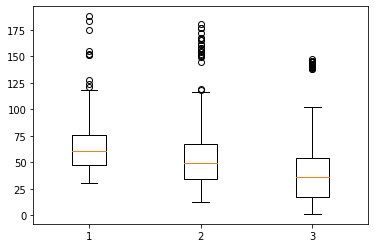

In [54]:
import matplotlib.pyplot as plt
x=[]
for i in clus:
    m=[]
    for j in clus[i]:
        m.extend(distance_matrix[j])
    x.append(m)
plt.boxplot(x)
plt.show()
    

In [55]:
distance_matrix[2][1]

44.76842951750572

In [56]:
distance_matrix[1][2]

48.754133283633166